In [ ]:
!pip install bs4
!pip install requests

In [ ]:
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import random
import pandas as pd

In [ ]:
BASE_URL = "https://www.amazon.in/s"
QUERY = "Sandals"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
}

In [ ]:
session= requests.Session()
retry = Retry(connect=3,backoff_factor=1,status_forcelist=[429,500,502,503,504])
adapter = HTTPAdapter(max_retries=retry)
session.mount("http://",adapter)
session.mount("https://",adapter)

In [ ]:
all_data = []

for page in range(1,20):
  params = {'k': QUERY, 'page': page}
  print(f'scraping page {page}...')

  try:
    response = session.get(BASE_URL, params=params, headers=HEADERS, timeout=10)
    response.raise_for_status()
  except requests.RequestException as e:
    print(f'Error on page {page}: {e}')
    continue

  soup = BeautifulSoup(response.text, 'html.parser')

  # Extract product information for the current page
  for result in soup.find_all('div', {'data-component-type': 's-search-result'}):
    BrandName_tag =result.find('span',{'class':'a-size-base-plus a-color-base'})
    ProductName_tag = result.find('a', {'class':'a-link-normal s-line-clamp-2 s-line-clamp-3-for-col-12 s-link-style a-text-normal'})
    Price_tag = result.find('span', class_='a-price-whole')
    ProductRating_tag = result.find('span', class_='a-icon-alt')
    ProductNoOfReviews = result.find('span', class_='a-size-mini puis-normal-weight-text s-underline-text')

    BrandName = BrandName_tag.get_text(strip=True) if BrandName_tag else None
    ProductName = ProductName_tag.get_text(strip=True) if ProductName_tag else None
    Price = Price_tag.get_text(strip=True) if Price_tag else None
    ProductRating = ProductRating_tag.get_text(strip=True) if ProductRating_tag else None
    productNoOfReview = ProductNoOfReviews.get_text(strip=True) if ProductNoOfReviews else None


    all_data.append({
        "BrandName": BrandName,
        "ProductName": ProductName,
        "Price": Price,
        "ProductRating": ProductRating,
        "ProductNoOfReview": productNoOfReview})
  #delay
  time.sleep(random.uniform(2, 5))

print(f"✅ Scraped {len(all_data)} products total")

scraping page 1...
scraping page 2...
scraping page 3...
scraping page 4...
scraping page 5...
scraping page 6...
scraping page 7...
scraping page 8...
scraping page 9...
scraping page 10...
scraping page 11...
scraping page 12...
scraping page 13...
scraping page 14...
scraping page 15...
scraping page 16...
scraping page 17...
scraping page 18...
scraping page 19...
✅ Scraped 318 products total


In [ ]:
df = pd.DataFrame(all_data)
display(df.head())

,BrandName,ProductName,Price,ProductRating,ProductNoOfReview
0,SPARX,Men's Ss 453 Sport Sandal,716,4.0 out of 5 stars,(38K)
1,SPARX,Men's Ss 101 Sport Sandal,643,4.2 out of 5 stars,(25.5K)
2,SPARX,Men's Ss 119 Sport Sandal,529.,4.0 out of 5 stars,(8.2K)
3,Hush Puppies,Hush Puppies Men's Slip-on Fisherman Sandal,"1,799",4.1 out of 5 stars,(3.1K)
4,SPARX,Men's Ss 485 Sport Sandal,651.,4.1 out of 5 stars,(9.3K)


In [ ]:
df.to_csv("sandals_amazon.csv")

In [ ]:
df=pd.read_csv('sandals_amazon.csv')

**DATA CLEANING**

In [ ]:
df['Price'] = df['Price'].astype(str).str.strip('₹').str.replace(',', '', regex=False).str.replace('.', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').astype('Int64')

In [ ]:
df["ProductRating"] = (df["ProductRating"].astype(str).str.extract(r"([\d.]+)").astype(float))

In [ ]:
df = df.rename(columns={'ProductNoOfReview': 'Reviews'})

In [ ]:
def clean_reviews(x):
    if pd.isna(x):
        return None
    x = str(x).strip("()").replace(",", "").strip()
    if x.lower() == "none" or x == "":
        return None
    if "K" in x:
        return int(float(x.replace("K", "")) * 1000)
    elif "M" in x:
        return int(float(x.replace("M", "")) * 1_000_000)
    else:
        try:
            return int(float(x))
        except:
            return None

df["Reviews"] = df["Reviews"].apply(clean_reviews).astype("Int64")

# Ensure 'Rating_Out_of_5' is float
df["ProductRating"] = df["ProductRating"].astype(float)

# Check types and sample output
print(df.dtypes)
print(df.head())


Unnamed: 0         int64
BrandName         object
ProductName       object
Price              Int64
ProductRating    float64
Reviews            Int64
dtype: object
   Unnamed: 0     BrandName                                  ProductName  \
0           0         SPARX                    Men's Ss 453 Sport Sandal   
1           1         SPARX                    Men's Ss 101 Sport Sandal   
2           2         SPARX                    Men's Ss 119 Sport Sandal   
3           3  Hush Puppies  Hush Puppies Men's Slip-on Fisherman Sandal   
4           4         SPARX                    Men's Ss 485 Sport Sandal   

   Price  ProductRating  Reviews  
0    716            4.0    38000  
1    643            4.2    25500  
2    529            4.0     8200  
3   1799            4.1     3100  
4    651            4.1     9300  


In [ ]:
df

,Unnamed: 0,BrandName,ProductName,Price,ProductRating,Reviews
0,0,SPARX,Men's Ss 453 Sport Sandal,716,4.0,38000
1,1,SPARX,Men's Ss 101 Sport Sandal,643,4.2,25500
2,2,SPARX,Men's Ss 119 Sport Sandal,529,4.0,8200
3,3,Hush Puppies,Hush Puppies Men's Slip-on Fisherman Sandal,1799,4.1,3100
4,4,SPARX,Men's Ss 485 Sport Sandal,651,4.1,9300
...,...,...,...,...,...,...
313,313,FUEL,Sandals & Floaters for Mens & Boys Comfortable...,998,3.8,166
314,314,PARAGON,Men’s Adjustable Stylish Sandals for Everyday ...,669,3.8,176
315,315,White Walkers,Genuine Leather Men's Black Sandals with Woven...,749,3.2,33
316,316,TRACER,"Causal Sandals for Men's, Stylish & Comfortabl...",1215,4.0,103


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     318 non-null    int64  
 1   BrandName      318 non-null    object 
 2   ProductName    318 non-null    object 
 3   Price          318 non-null    Int64  
 4   ProductRating  317 non-null    float64
 5   Reviews        317 non-null    Int64  
dtypes: Int64(2), float64(1), int64(1), object(2)
memory usage: 15.7+ KB


In [ ]:
df.describe()

,Unnamed: 0,Price,ProductRating,Reviews
count,318.000000,318.0,317.000000,317.0
mean,158.500000,938.650943,3.881073,1311.176656
std,91.942917,544.960984,0.303599,3459.327034
min,0.000000,244.0,2.100000,2.0
25%,79.250000,584.5,3.800000,111.0
50%,158.500000,749.0,3.900000,336.0
75%,237.750000,1076.0,4.100000,998.0
max,317.000000,3395.0,5.000000,38000.0


**IMPORTING DATAFRAME TO SQL**

In [ ]:
!pip install sqlalchemy

In [ ]:
import sqlalchemy
import sqlite3

In [ ]:
conn= sqlite3.connect('sandals.db')

In [ ]:
cursor = conn.cursor()

In [ ]:
df.to_sql("sandals",conn,index=False,if_exists='replace')

318

In [ ]:
cursor.execute('select count(*)from sandals')
print('rows stored: ',cursor.fetchone()[0])

rows stored:  318


In [ ]:
conn.close()

In [ ]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///sandals.db')
df= pd.read_sql('select * from sandals',con=engine)

In [ ]:
!pip install mysql-connector-python sqlalchemy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 58.5 MB/s eta 0:00:00


In [ ]:
import sqlite3

conn = sqlite3.connect('sandals.db')
with open('sandals.sql', 'w') as f:
    for line in conn.iterdump():
        f.write('%s\n' % line)
conn.close()

In [ ]:
from google.colab import files

files.download('sandals.sql')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.to_csv('sandals.csv',index=False)

**STATISTICAL ANALYSIS**

In [ ]:




# --- Rating Distribution ---


# --- ---


**Exploratory Data Analysis (EDA)**

**Descriptive Statistics**

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [39]:

print("\n📊 Descriptive Statistics:")
print(df[["Price", "ProductRating", "Reviews"]].describe())


📊 Descriptive Statistics:
             Price  ProductRating       Reviews
count   318.000000     317.000000    317.000000
mean    938.650943       3.881073   1311.176656
std     544.960984       0.303599   3459.327034
min     244.000000       2.100000      2.000000
25%     584.500000       3.800000    111.000000
50%     749.000000       3.900000    336.000000
75%    1076.000000       4.100000    998.000000
max    3395.000000       5.000000  38000.000000


**Price Distribution**

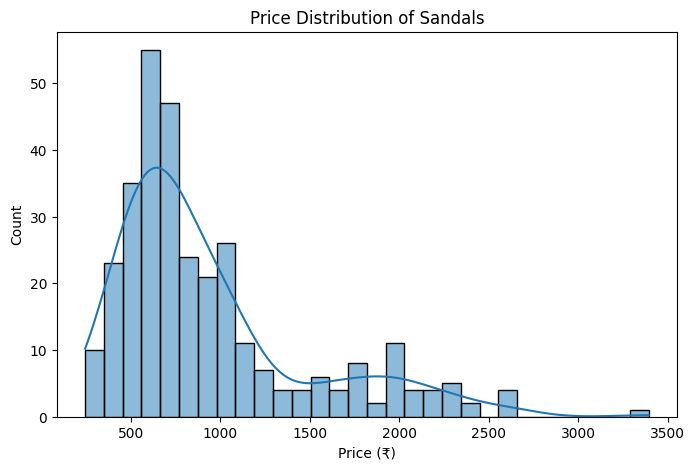

In [45]:
plt.figure(figsize=(8,5))
sns.histplot(df["Price"], bins=30, kde=True)
plt.title("Price Distribution of Sandals")
plt.xlabel("Price (₹)")
plt.ylabel("Count")
plt.show()

**Rating Distribution**

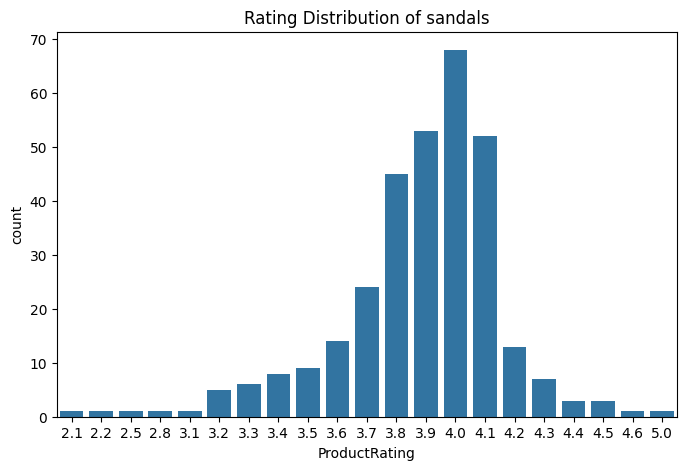

In [44]:
plt.figure(figsize=(8,5))
sns.countplot(x="ProductRating", data=df)
plt.title("Rating Distribution of sandals")
plt.show()

**Correlation Heatmap**

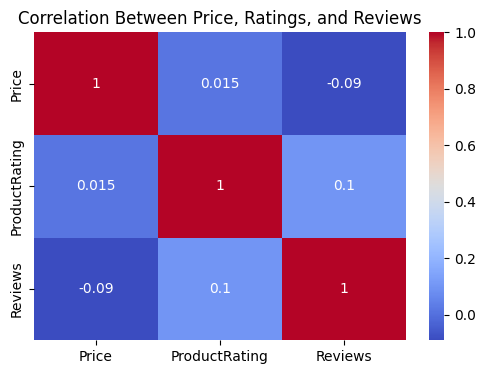

In [43]:
plt.figure(figsize=(6,4))
sns.heatmap(df[["Price", "ProductRating", "Reviews"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Price, Ratings, and Reviews")
plt.show()

**Outlier Detection using Z-score**

In [47]:
z_scores = np.abs(stats.zscore(df[["Price", "ProductRating", "Reviews"]].dropna()))
outliers = (z_scores > 3).sum()
print("\n⚙️ Outlier Count per Column:")
print(outliers)


⚙️ Outlier Count per Column:
17


**Hypothesis Testing**

In [48]:
cheap = df[df["Price"] <= 2000]["ProductRating"].dropna()
expensive = df[df["Price"] > 2000]["ProductRating"].dropna()

t_stat, p_val = stats.ttest_ind(cheap, expensive, equal_var=False, nan_policy='omit')
print("\n🧪 Hypothesis Test: ProductRating vs Price Category")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.3f}")

if p_val < 0.05:
    print("➡️ Reject Null Hypothesis: Price category significantly affects ratings.")
else:
    print("➡️ Fail to Reject Null Hypothesis: No significant difference.")


🧪 Hypothesis Test: ProductRating vs Price Category
T-statistic: 0.206, P-value: 0.839
➡️ Fail to Reject Null Hypothesis: No significant difference.
